In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
from sklearn.ensemble import GradientBoostingRegressor#
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
import torch
from sklearn.preprocessing import StandardScaler
import missingno as msno

# Importing Dataset 

In [3]:
df  = pd.read_csv("data/kaggle_1.csv")
df.sample(20)

,Unnamed: 0.1,Unnamed: 0,text,category,date,title,author
2415,2415,2415.0,<BOS> Is he your brother? he whispered. No; my...,England -- Social life and customs -- 19th cen...,1891.0,Amethyst: The Story of a Beauty,ColeridgeChristabelRChristabelRose
6089,6089,6089.0,<BOS> Getting off she ran into the house and c...,Vacations -- Juvenile fiction; Camp Fire Girls...,1916.0,"The Camp Fire Girls at Onoway House; Or, The M...",FreyHildegardG
6005,6005,6005.0,<BOS> The man sat up and produced a shabby car...,"London (England) -- Fiction; Thorndyke, Doctor...",1912.0,The Adventures of Dr. Thorndyke\n(The Singing ...,FreemanRAustinRichardAustin
2845,2845,2845.0,<BOS> Drink to success. Amen! said Frank. He t...,Science fiction; Inventors -- Fiction; Dime no...,1892.0,"Frank Reade, Jr., with his new steam man in Me...",SenarensLuis
8064,8064,8064.0,NaN,NaN,NaN,NaN,NaN
7812,7812,7812.0,"<BOS> I suppose so, replied Tony. I think I wo...",London (England) -- Fiction; Love stories; Adv...,1918.0,The Lady from Long Acre,BridgesVictor
940,940,940.0,"<BOS> His eye, in answer, must give but a dubi...",Fiction,1890.0,Alas! A Novel,BroughtonRhoda
9692,9692,NaN,I\nThe Time Traveller ( for so it will be conv...,Narrative fiction,1888,The Time Machine,"Wells, Herbert George"
3701,3701,3701.0,"<BOS> These they must be taught, and taught ve...",Dogs -- Juvenile fiction; Conduct of life -- J...,1854.0,"Bruno; or, lessons of fidelity, patience, and ...",AbbottJacob
8672,8672,8672.0,NaN,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9729 entries, 0 to 9728
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0.1  9729 non-null   int64  
 1   Unnamed: 0    9396 non-null   float64
 2   text          8295 non-null   object 
 3   category      8295 non-null   object 
 4   date          8295 non-null   object 
 5   title         8295 non-null   object 
 6   author        8281 non-null   object 
dtypes: float64(1), int64(1), object(5)
memory usage: 532.2+ KB


# Checking for missing values

<Axes: >

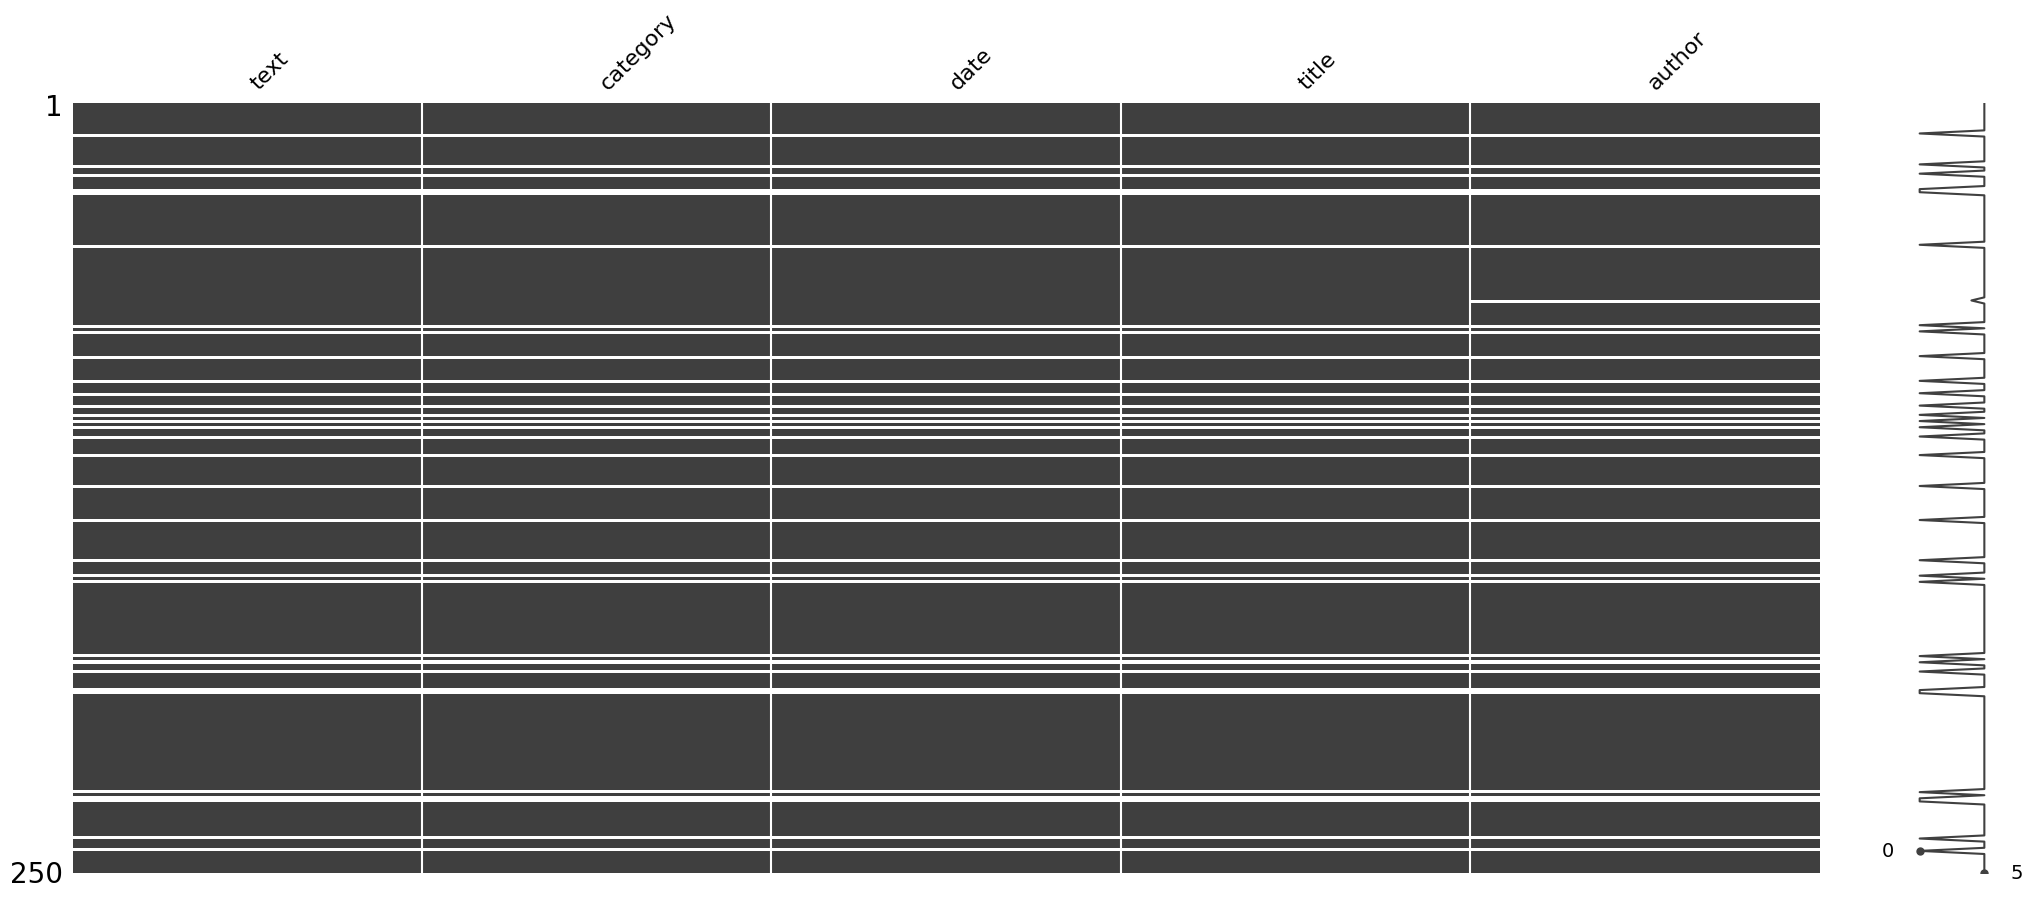

In [5]:
df.drop(["Unnamed: 0.1","Unnamed: 0"],axis=1,inplace=True)
msno.matrix(df.sample(250))

In [6]:
df.dropna(inplace=True)

# Removing all non-alphanumeric characters followed by other errors in the text

In [7]:
df['text'] = df['text'].replace('ſ', 's', regex=True)
df['text'] = df['text'].replace('<BOS>', ' ', regex=True)
df['text'] = df['text'].replace("[^a-zA-Z0-9 ']", ' ', regex=True)
df['text'] = df['text'].replace("@", ' ', regex=True)
df['text'] = df['text'].replace("EOS", ' ', regex=True)
df['text'] = df['text'].replace("haue", ' ', regex=True)
df['text'] = df['text'].replace("vnto", ' ', regex=True)

# Splitting the years into decades and restricting them to the range from 1500 to 1920

In [8]:
df['date'] = pd.to_numeric(df['date'], errors='coerce', downcast='integer')
df['decade'] = (df['date'] // 10) * 10

In [9]:
df = df[(df["decade"] >= 1500) & (df["decade"] < 1920)]


In [10]:
# Splitting the text into multiple sections for books that have a lot of data

def split_rows_based_on_word_count(df, column_name, word_count_threshold):
    new_rows = []

    for index, row in df.iterrows():
        text = row[column_name]
        words = text.split()
        
        if len(words) > word_count_threshold:
            # Split the text into multiple rows
            split_texts = [words[i:i+word_count_threshold] for i in range(0, len(words), word_count_threshold)]
            
            for split_text in split_texts:
                new_row = row.copy()
                new_row[column_name] = ' '.join(split_text)
                new_rows.append(new_row)
        else:
            # Keep the row as it is
            new_rows.append(row)

    return pd.DataFrame(new_rows, columns=df.columns)


word_count_threshold = 750  # Set your desired word count threshold
df = split_rows_based_on_word_count(df, 'text', word_count_threshold)

# Now, 'new_dataframe' contains the rows split based on the word count threshold


In [11]:
threshold = 800
df = df.groupby('decade').head(threshold)
print(df)


                                                   text  \
0     TabulaChronicles of England 1502Approx 1361 KB...   
0     text with mnemonic sdata character entities di...   
0     Brytayneleafc v viIoathan kynge of IewesAmaria...   
0     quevult saluus esseMercus popeIulius popeConst...   
0     the fourth popeInnocencius the fourth popeleaf...   
...                                                 ...   
9646  appealed to me the kind of nature romance whic...   
9646  long delayed Yet she lingered with us six week...   
9646  exemplified in the very lively interest which ...   
9646  not what awakened in my soul The two retreats ...   
9646  into dire distress before very long we learned...   

                   category    date           title         author  decade  
0               unknown.xml  1502.0          tabula  ranulf-higden  1500.0  
0               unknown.xml  1502.0          tabula  ranulf-higden  1500.0  
0               unknown.xml  1502.0          tabula  ranulf-

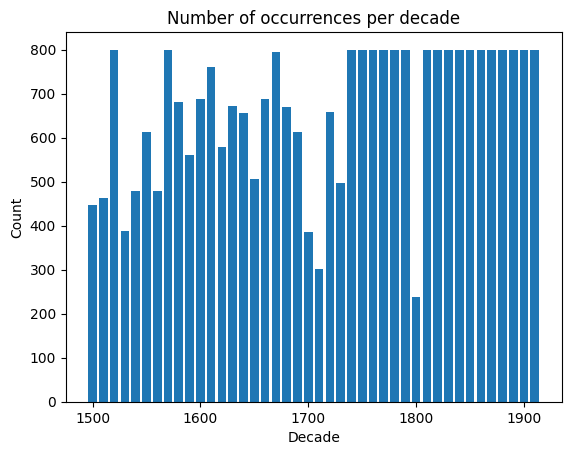

In [12]:
# Visualizing according to number of rows per decade to better understand the data distribution
decade_counts = df['decade'].value_counts().sort_index()

# Create a bar graph
plt.bar(decade_counts.index, decade_counts.values, width=8)  # Adjust the width as needed

# Set labels and title
plt.xlabel('Decade')
plt.ylabel('Count')
plt.title('Number of occurrences per decade')

# Display the graph
plt.show()


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 28012 entries, 0 to 9646
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   text      28012 non-null  object 
 1   category  28012 non-null  object 
 2   date      28012 non-null  float64
 3   title     28012 non-null  object 
 4   author    28012 non-null  object 
 5   decade    28012 non-null  float64
dtypes: float64(2), object(4)
memory usage: 1.5+ MB


In [14]:
# Randomly selecting around 27.5K rows from the dataset. This threshold was set due to hardware constraints

df = df.sample(1000)

# SVR - TfIdf 

In [79]:

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=4000)
train_text_features = tfidf_vectorizer.fit_transform(train_data)
test_text_features = tfidf_vectorizer.transform(test_data)

# Initialize and train the SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(train_text_features, train_labels)

# Predictions
train_predictions = svr_model.predict(train_text_features)
test_predictions = svr_model.predict(test_text_features)

# Calculate RMSE, MAE, and R2 Score
train_rmse = sqrt(mean_squared_error(train_labels, train_predictions))
test_rmse = sqrt(mean_squared_error(test_labels, test_predictions))
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

# Feature Importance Plot - Not applicable for SVR

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, train_predictions, color='blue', label='Training data', alpha=0.5)
#plt.scatter(test_labels, test_predictions, color='red', label='Testing data', alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('SVR Model Predictions')
plt.xlabel('Actual Date')
plt.ylabel('Predicted Date')
plt.grid(True)
plt.legend()
plt.show()


# SVR - Word2Vec

In [52]:


# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to Word2Vec features
# Assuming 'text' column contains lists of tokenized words
word2vec_model = Word2Vec(sentences=train_data, vector_size=400, window=5, min_count=1, workers=16)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

# Function to average word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Function to generate word vectors for each sentence
def wordvec_features(X, model, vocabulary, num_features):
    features = [average_word_vectors(words, model, vocabulary, num_features)
                for words in X  if words]
    return np.array(features)

# Transform text data to Word2Vec features
train_text_features = wordvec_features(train_data, word_vectors, max_words, 400)
test_text_features = wordvec_features(test_data, word_vectors, max_words, 400)

# Initialize and train the SVR model
svr_model = SVR(kernel='linear')
svr_model.fit(train_text_features, train_labels)

# Predictions
train_predictions = svr_model.predict(train_text_features)
test_predictions = svr_model.predict(test_text_features)

# Calculate RMSE, MAE, and R2 Score
train_rmse = sqrt(mean_squared_error(train_labels, train_predictions))
test_rmse = sqrt(mean_squared_error(test_labels, test_predictions))
train_mae = mean_absolute_error(train_labels, train_predictions)
test_mae = mean_absolute_error(test_labels, test_predictions)
train_r2 = r2_score(train_labels, train_predictions)
test_r2 = r2_score(test_labels, test_predictions)

print("Training RMSE:", train_rmse)
print("Testing RMSE:", test_rmse)
print("Training MAE:", train_mae)
print("Testing MAE:", test_mae)
print("Training R-squared:", train_r2)
print("Testing R-squared:", test_r2)

# Feature Importance Plot - Not applicable for SVR

# Plotting the results
plt.figure(figsize=(10, 6))
plt.scatter(train_labels, train_predictions, color='blue', label='Training data', alpha=0.5)
#plt.scatter(test_labels, test_predictions, color='red', label='Testing data', alpha=0.5)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('SVR Model Predictions')
plt.xlabel('Actual Date')
plt.ylabel('Predicted Date')
plt.legend()
plt.show()

# Gradient Boosting - TfIdf

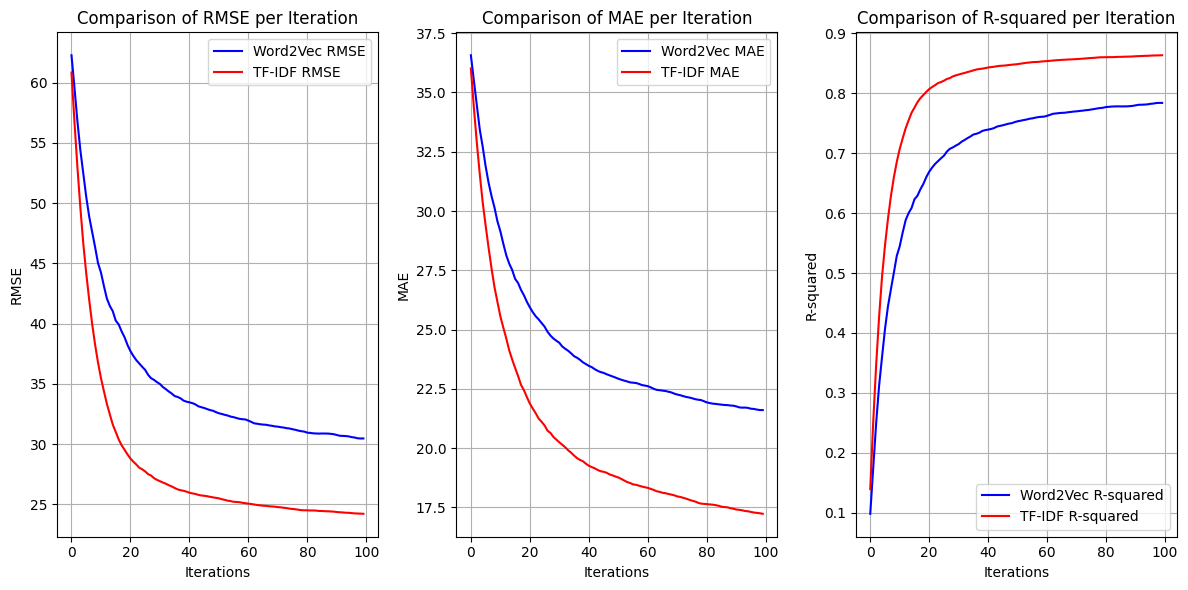

In [58]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

# Assuming df is your DataFrame

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Convert text data to TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=4000)
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Convert text data to Word2Vec features
word2vec_model = Word2Vec(sentences=train_data, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

train_text_features_wv = wordvec_features(train_data, word_vectors, max_words, 100)
test_text_features_wv = wordvec_features(test_data, word_vectors, max_words, 100)

# Initialize and train the Gradient Boosting model for TF-IDF
gb_model_tfidf = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model_tfidf.fit(train_text_features_tfidf, train_labels)

# Initialize and train the Gradient Boosting model for Word2Vec
gb_model_wv = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model_wv.fit(train_text_features_wv, train_labels)

# Track RMSE, MAE, and R-squared over iterations for test data for TF-IDF
test_rmse_scores_tfidf = []
test_mae_scores_tfidf = []
test_r2_scores_tfidf = []
for i, y_pred in enumerate(gb_model_tfidf.staged_predict(test_text_features_tfidf)):
    test_rmse_scores_tfidf.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_tfidf.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_tfidf.append(r2_score(test_labels, y_pred))

# Track RMSE, MAE, and R-squared over iterations for test data for Word2Vec
test_rmse_scores_wv = []
test_mae_scores_wv = []
test_r2_scores_wv = []
for i, y_pred in enumerate(gb_model_wv.staged_predict(test_text_features_wv)):
    test_rmse_scores_wv.append(sqrt(mean_squared_error(test_labels, y_pred)))
    test_mae_scores_wv.append(mean_absolute_error(test_labels, y_pred))
    test_r2_scores_wv.append(r2_score(test_labels, y_pred))

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(test_rmse_scores_wv, label='Word2Vec RMSE', color='blue')
plt.plot(test_rmse_scores_tfidf, label='TF-IDF RMSE', color='red')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(test_mae_scores_wv, label='Word2Vec MAE', color='blue')
plt.plot(test_mae_scores_tfidf, label='TF-IDF MAE', color='red')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(test_r2_scores_wv, label='Word2Vec R-squared', color='blue')
plt.plot(test_r2_scores_tfidf, label='TF-IDF R-squared', color='red')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


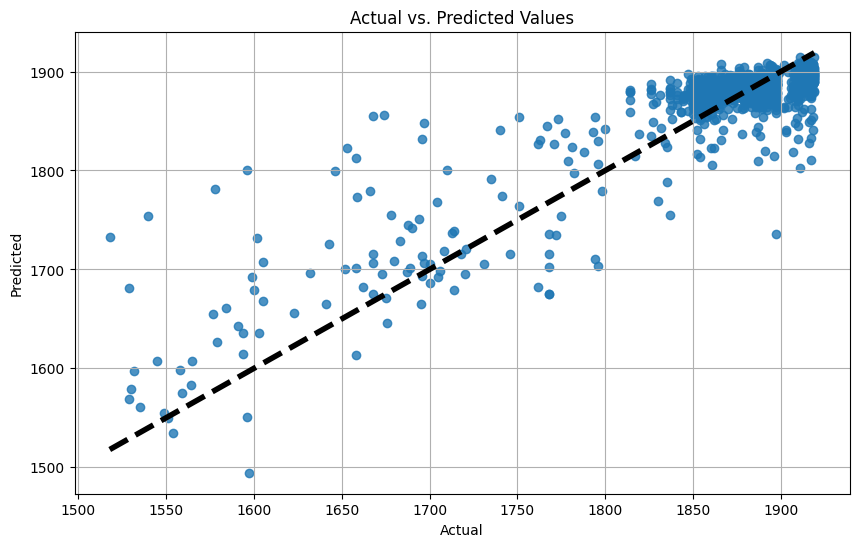

In [ ]:

# Convert text data to Word2Vec features
word2vec_model = Word2Vec(sentences=train_data, vector_size=100, window=5, min_count=1, workers=4)
word2vec_model.train(train_data, total_examples=len(train_data), epochs=10)
word_vectors = word2vec_model.wv
max_words = word_vectors.key_to_index

# Function to average word vectors for a sentence
def average_word_vectors(words, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in words:
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
    return feature_vector

# Function to generate word vectors for each sentence
def wordvec_features(X, model, vocabulary, num_features):
    features = [average_word_vectors(words, model, vocabulary, num_features)
                for words in X if words]
    return np.array(features)

# Transform text data to Word2Vec features
train_text_features = wordvec_features(train_data, word_vectors, max_words, 100)
test_text_features = wordvec_features(test_data, word_vectors, max_words, 100)

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(train_text_features, train_labels)

# Track RMSE loss over iterations for test data
test_score = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(test_text_features)):
    test_score[i] = sqrt(mean_squared_error(test_labels, y_pred))

# Track RMSE loss over iterations for training data
train_score = np.zeros((gb_model.n_estimators,), dtype=np.float64)
for i, y_pred in enumerate(gb_model.staged_predict(train_text_features)):
    train_score[i] = sqrt(mean_squared_error(train_labels, y_pred))

# Generate predictions
predictions = gb_model.predict(test_text_features)

# Plotting Predictions vs Actual
plt.figure(figsize=(10, 6))
plt.scatter(test_labels, predictions, alpha=0.8)
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=4)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()


# Xgboost Tfidf and Word2vec

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[0]	validation_0-rmse:88.64543	validation_0-mae:75.88412
[1]	validation_0-rmse:68.19646	validation_0-mae:57.26482
[2]	validation_0-rmse:54.54280	validation_0-mae:45.02371
[3]	validation_0-rmse:45.80204	validation_0-mae:36.74408
[4]	validation_0-rmse:40.31699	validation_0-mae:31.14865
[5]	validation_0-rmse:37.01095	validation_0-mae:27.64146
[6]	validation_0-rmse:34.92362	validation_0-mae:25.37279
[7]	validation_0-rmse:33.63756	validation_0-mae:23.96536
[8]	validation_0-rmse:32.68302	validation_0-mae:22.98369
[9]	validation_0-rmse:31.98066	validation_0-mae:22.32680
[10]	validation_0-rmse:31.40950	validation_0-mae:21.80688
[11]	validation_0-rmse:31.03971	validation_0-mae:21.53094
[12]	validation_0-rmse:30.75197	validation_0-mae:21.27372
[13]	validation_0-rmse:30.55643	validation_0-mae:21.10917
[14]	validation_0-rmse:30.31164	validation_0-mae:20.94344
[15]	validation_0-rmse:30.21265	validation_0-mae:20.84878
[16]	validation_0-rmse:30.04886	validation_0-mae:20.72736
[17]	validation_0-rmse:2

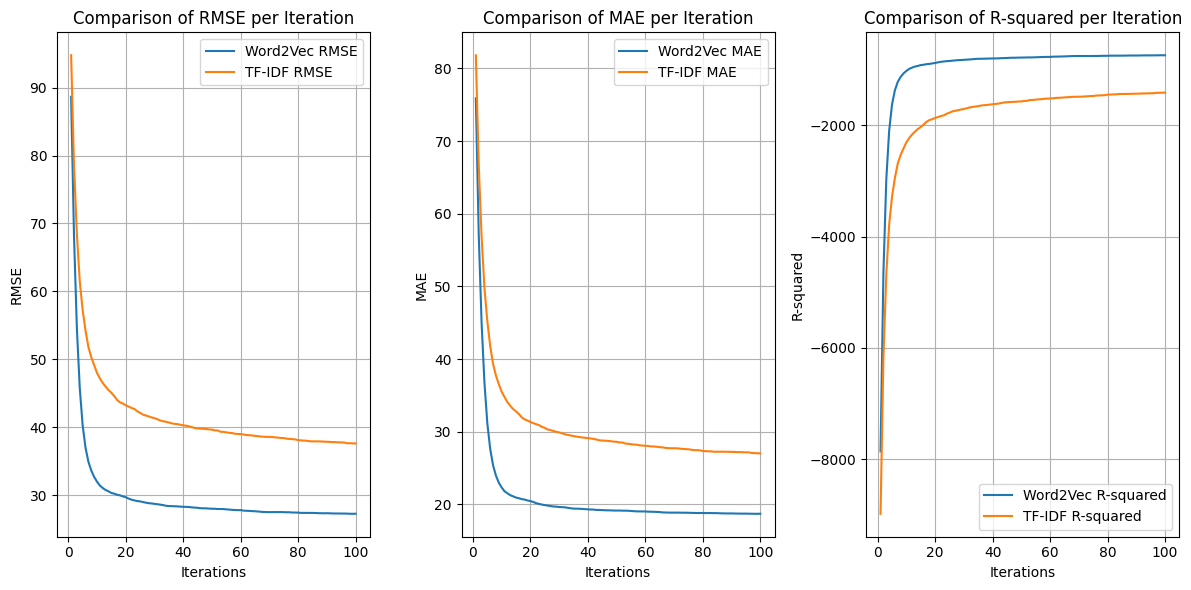

In [76]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Tokenize the text data for Word2Vec
tokenized_data = [text.split() for text in train_data]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=400, window=9, min_count=1, workers=12)

# Convert text data to Word2Vec embeddings
def get_text_embedding(text, model):
    embedding = [model.wv[word] for word in text.split() if word in model.wv]
    if embedding:
        return sum(embedding) / len(embedding)
    else:
        return np.zeros(400)  # Adjusted to match vector_size

train_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in train_data])
test_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in test_data])

# Train and evaluate XGBoost with Word2Vec
xgb_model_wv = XGBRegressor()
eval_set_wv = [(test_text_features_wv, test_labels)]
xgb_model_wv.fit(train_text_features_wv, train_labels, eval_metric=["rmse", "mae", "rmse", "mae"], eval_set=eval_set_wv, verbose=True)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Train and evaluate XGBoost with TF-IDF
xgb_model_tfidf = XGBRegressor()
eval_set_tfidf = [(test_text_features_tfidf, test_labels)]
xgb_model_tfidf.fit(train_text_features_tfidf, train_labels, eval_metric=["rmse", "mae", "rmse", "mae"], eval_set=eval_set_tfidf, verbose=True)

# Get evaluation results for Word2Vec
results_wv = xgb_model_wv.evals_result()
rmse_wv = results_wv['validation_0']['rmse']
mae_wv = results_wv['validation_0']['mae']
r_squared_wv = [1 - (rmse ** 2) for rmse in rmse_wv]
epochs_wv = range(1, len(rmse_wv) + 1)

# Get evaluation results for TF-IDF
results_tfidf = xgb_model_tfidf.evals_result()
rmse_tfidf = results_tfidf['validation_0']['rmse']
mae_tfidf = results_tfidf['validation_0']['mae']
r_squared_tfidf = [1 - (rmse ** 2) for rmse in rmse_tfidf]
epochs_tfidf = range(1, len(rmse_tfidf) + 1)

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(epochs_wv, rmse_wv, label='Word2Vec RMSE')
plt.plot(epochs_tfidf, rmse_tfidf, label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs_wv, mae_wv, label='Word2Vec MAE')
plt.plot(epochs_tfidf, mae_tfidf, label='TF-IDF MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs_wv, r_squared_wv, label='Word2Vec R-squared')
plt.plot(epochs_tfidf, r_squared_tfidf, label='TF-IDF R-squared')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


[0]	validation_0-rmse:89.01627	validation_0-mae:76.16149
[1]	validation_0-rmse:68.67426	validation_0-mae:57.78299
[2]	validation_0-rmse:55.05228	validation_0-mae:45.54295
[3]	validation_0-rmse:46.15350	validation_0-mae:37.29097
[4]	validation_0-rmse:40.72564	validation_0-mae:31.85735
[5]	validation_0-rmse:37.44709	validation_0-mae:28.32438
[6]	validation_0-rmse:35.45168	validation_0-mae:26.06393
[7]	validation_0-rmse:34.09458	validation_0-mae:24.59163
[8]	validation_0-rmse:33.13501	validation_0-mae:23.51686
[9]	validation_0-rmse:32.29151	validation_0-mae:22.75241
[10]	validation_0-rmse:31.76464	validation_0-mae:22.26127
[11]	validation_0-rmse:31.36080	validation_0-mae:21.88384
[12]	validation_0-rmse:30.92057	validation_0-mae:21.50369
[13]	validation_0-rmse:30.59943	validation_0-mae:21.23932
[14]	validation_0-rmse:30.37316	validation_0-mae:21.03305
[15]	validation_0-rmse:30.13090	validation_0-mae:20.84794
[16]	validation_0-rmse:29.96266	validation_0-mae:20.72493
[17]	validation_0-rmse:2

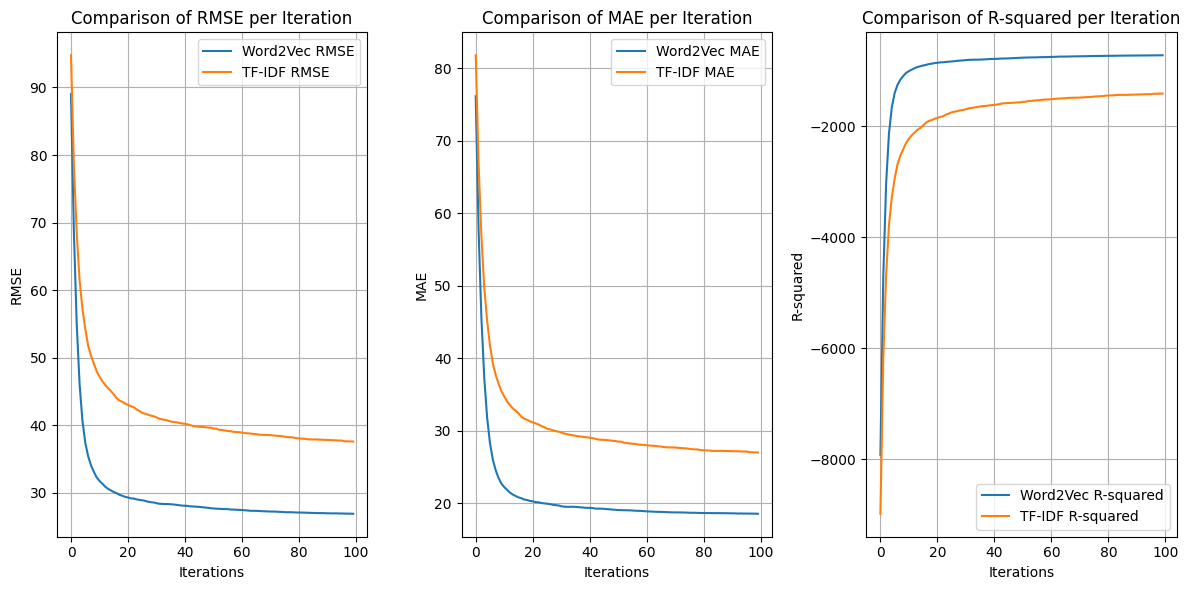

In [77]:
import pandas as pd
from sklearn.model_selection import train_test_split
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt


# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Tokenize the text data for Word2Vec
tokenized_data = [text.split() for text in train_data]

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_data, vector_size=400, window=9, min_count=1, workers=4)

# Convert text data to Word2Vec embeddings
def get_text_embedding(text, model):
    embedding = [model.wv[word] for word in text.split() if word in model.wv]
    if embedding:
        return sum(embedding) / len(embedding)
    else:
        return np.zeros(400)  # Adjusted to match vector_size

train_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in train_data])
test_text_features_wv = np.array([get_text_embedding(text, word2vec_model) for text in test_data])

# Train and evaluate XGBoost with Word2Vec
xgb_model_wv = XGBRegressor()
eval_set_wv = [(test_text_features_wv, test_labels)]
xgb_model_wv.fit(train_text_features_wv, train_labels, eval_metric=["rmse", "mae"], eval_set=eval_set_wv, verbose=True)

# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
train_text_features_tfidf = tfidf_vectorizer.fit_transform(train_data)
test_text_features_tfidf = tfidf_vectorizer.transform(test_data)

# Train and evaluate XGBoost with TF-IDF
xgb_model_tfidf = XGBRegressor()
eval_set_tfidf = [(test_text_features_tfidf, test_labels)]
xgb_model_tfidf.fit(train_text_features_tfidf, train_labels, eval_metric=["rmse", "mae"], eval_set=eval_set_tfidf, verbose=True)

# Get evaluation results for Word2Vec
results_wv = xgb_model_wv.evals_result()
epochs_wv = len(results_wv['validation_0']['rmse'])
x_axis_wv = range(0, epochs_wv)

# Get evaluation results for TF-IDF
results_tfidf = xgb_model_tfidf.evals_result()
epochs_tfidf = len(results_tfidf['validation_0']['rmse'])
x_axis_tfidf = range(0, epochs_tfidf)

# Calculate R-squared for Word2Vec
rmse_wv = results_wv['validation_0']['rmse']
r_squared_wv = [1 - (rmse ** 2) for rmse in rmse_wv]

# Calculate R-squared for TF-IDF
rmse_tfidf = results_tfidf['validation_0']['rmse']
r_squared_tfidf = [1 - (rmse ** 2) for rmse in rmse_tfidf]

# Plot comparison of RMSE, MAE, and R-squared per iteration between Word2Vec and TF-IDF
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.plot(x_axis_wv, results_wv['validation_0']['rmse'], label='Word2Vec RMSE')
plt.plot(x_axis_tfidf, results_tfidf['validation_0']['rmse'], label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(x_axis_wv, results_wv['validation_0']['mae'], label='Word2Vec MAE')
plt.plot(x_axis_tfidf, results_tfidf['validation_0']['mae'], label='TF-IDF MAE')
plt.xlabel('Iterations')
plt.ylabel('MAE')
plt.title('Comparison of MAE per Iteration')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(x_axis_wv, r_squared_wv, label='Word2Vec R-squared')
plt.plot(x_axis_tfidf, r_squared_tfidf, label='TF-IDF R-squared')
plt.xlabel('Iterations')
plt.ylabel('R-squared')
plt.title('Comparison of R-squared per Iteration')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [78]:
predictions_wv = xgb_model_wv.predict(test_text_features_wv)

# Making predictions with the TF-IDF model
predictions_tfidf = xgb_model_tfidf.predict(test_text_features_tfidf.toarray()) 

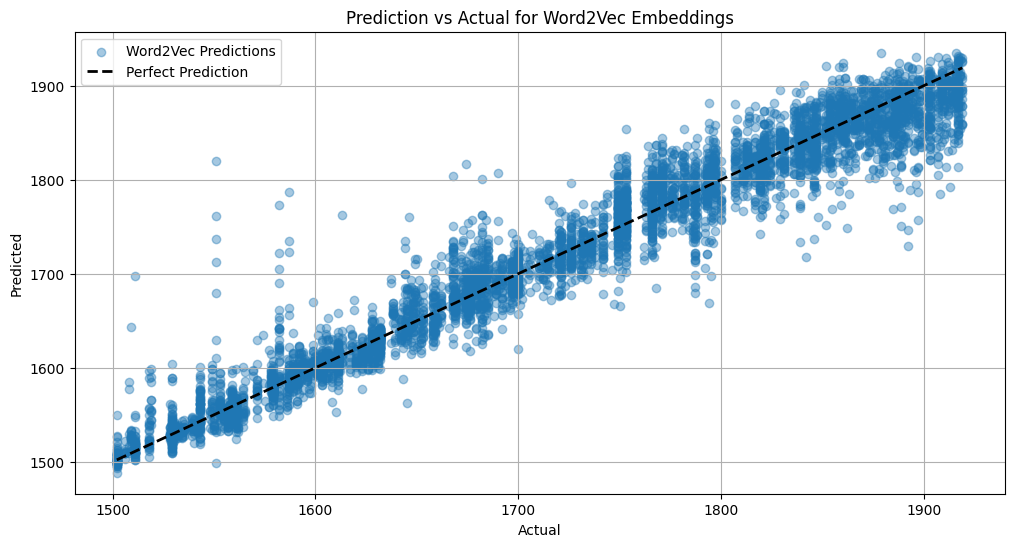

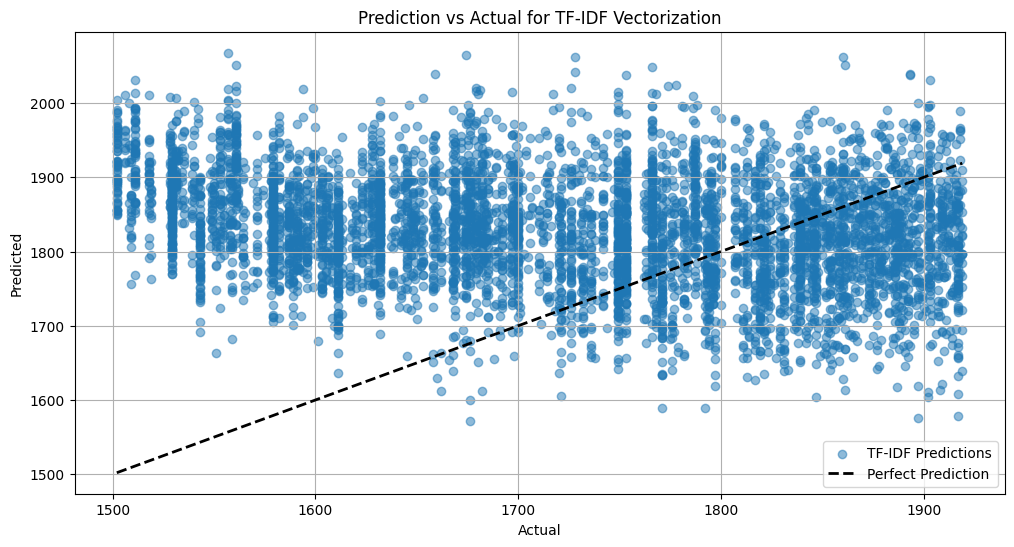

In [27]:
plt.figure(figsize=(12, 6))
plt.scatter(test_labels, predictions_wv, alpha=0.4, label='Word2Vec Predictions')
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual for Word2Vec Embeddings')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Prediction vs Actual for TF-IDF
plt.figure(figsize=(12, 6))
plt.scatter(test_labels, predictions_tfidf, alpha=0.5, label='TF-IDF Predictions')
plt.plot([test_labels.min(), test_labels.max()], [test_labels.min(), test_labels.max()], 'k--', lw=2, label='Perfect Prediction')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Prediction vs Actual for TF-IDF Vectorization')
plt.legend()
plt.grid(True)
plt.show()

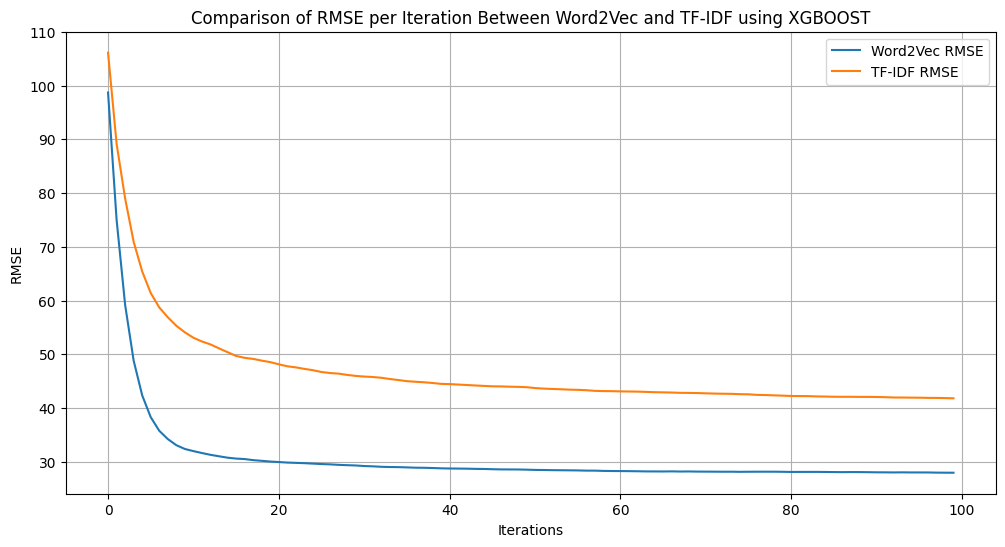

<Figure size 640x480 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt

# Assuming x_axis_wv, results_wv['validation_0']['rmse'], x_axis_tfidf, results_tfidf['validation_0']['rmse'] are defined
plt.figure(figsize=(12, 6))
plt.plot(x_axis_wv, results_wv['validation_0']['rmse'], label='Word2Vec RMSE')
plt.plot(x_axis_tfidf, results_tfidf['validation_0']['rmse'], label='TF-IDF RMSE')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Comparison of RMSE per Iteration Between Word2Vec and TF-IDF using XGBOOST')
plt.legend()
plt.grid(True)

# To display the chart on screen
plt.show()

# To save the figure with a transparent background
plt.savefig('comparison_chart_transparent.png', transparent=True)


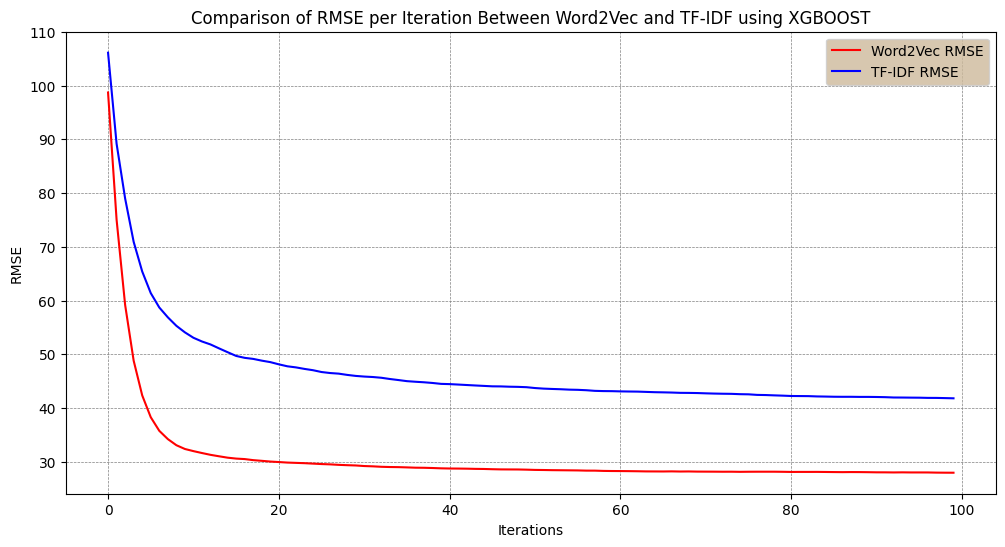

<Figure size 640x480 with 0 Axes>

# DistilBERT 

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split


# Sample DataFrame (replace this with your actual data)

# Assuming df is defined

# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Scale labels
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.values.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.values.reshape(-1, 1)).flatten()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"  # You can use any other transformer model available in the Hugging Face model hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Regression with one output label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Tokenize the text data
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data.tolist(), truncation=True, padding=True)

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels_scaled, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels_scaled, dtype=torch.float32).to(device)

# Convert data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                                               torch.tensor(train_encodings['attention_mask']).to(device),
                                               train_labels_tensor)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                              torch.tensor(test_encodings['attention_mask']).to(device),
                                              test_labels_tensor)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training
model.train()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=38, shuffle=True)

for epoch in range(2):  # Adjust the number of epochs as needed
    print('epoch')
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
        loss = outputs.loss
        loss.backward()
        optimizer.step()



Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch
epoch


In [16]:
# Evaluation
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=38, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze(1)
        predictions.extend(preds.tolist())

# Scale predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

rmse_distilbert = sqrt(mean_squared_error(test_labels, predictions))



In [17]:
print(f"Root Mean Squared Error (RMSE): {rmse_distilbert}")

Root Mean Squared Error (RMSE): 49.36178884381137


In [18]:
from sklearn.metrics import r2_score, mean_absolute_error

# Calculate R-squared (R2)
r_squared = r2_score(test_labels, predictions)
print(f"R-squared (R2): {r_squared}")

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_labels, predictions)
print(f"Mean Absolute Error (MAE): {mae}")

R-squared (R2): 0.8162166336292443
Mean Absolute Error (MAE): 38.3875773941053


In [25]:
import numpy as np
import shap

# Define a function to get predictions from the model
def model_predict(input_text):
    model.eval()
    with torch.no_grad():
        encodings = tokenizer(input_text, truncation=True, padding=True, return_tensors='pt').to(device)
        outputs = model(**encodings)
        preds = outputs.logits.squeeze(1)
    return preds.cpu().numpy()

# Wrap the model's forward function so that SHAP can understand it
explainer = shap.Explainer(model_predict, tokenizer)

token_val = [str(i) for i in test_data.values]
# Explain the predictions
print(list(test_data.values))
shap_values = explainer(list(test_data.values)[0], fixed_context=1)

# Plot the SHAP values (if needed)
shap.summary_plot(shap_values, test_data)


['noted of purpose to carie home to his countrie to serue when time should come He founde there other lawes also but of them he made no reckoning Nowe there was one man that aboue the rest was reputedwise and skilfull in matters of state gouernment who was calledThales with whomLycurgusdyd so much by intreatie and for familier friendshippe that he persuaded him to goe with him SPARTA ThisThaleswas called the Poet Harper Thales a poet harper whereupon he had that title and name but in effect he sange all that the best and sufficientest gouernours of the worlde could deuise For all his songes were goodly ditties wherein he dyd exhorte and persuade the people to liue vnder obedience of the law in peace concorde one with the other His words were set out with such tunes countenance accents that were so full of swetenes harmony and pearsing that inwardly it melted mens heartes and drue the hearers of a loue to like the most honest things and to leaue all hatred enmitie sedition and diuision 

ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [26]:


# Split the data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    df['text'], df['date'], test_size=0.2, random_state=42
)

# Scale labels
scaler = StandardScaler()
train_labels_scaled = scaler.fit_transform(train_labels.values.reshape(-1, 1)).flatten()
test_labels_scaled = scaler.transform(test_labels.values.reshape(-1, 1)).flatten()

# Load pre-trained model and tokenizer
model_name = "distilbert-base-uncased"  # You can use any other transformer model available in the Hugging Face model hub
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1)  # Regression with one output label

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

# Tokenize the text data
train_encodings = tokenizer(train_data.tolist(), truncation=True, padding=True)
test_encodings = tokenizer(test_data.tolist(), truncation=True, padding=True)

# Convert labels to tensors
train_labels_tensor = torch.tensor(train_labels_scaled, dtype=torch.float32).to(device)
test_labels_tensor = torch.tensor(test_labels_scaled, dtype=torch.float32).to(device)

# Convert data to PyTorch tensors
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']).to(device),
                                               torch.tensor(train_encodings['attention_mask']).to(device),
                                               train_labels_tensor)

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']).to(device),
                                              torch.tensor(test_encodings['attention_mask']).to(device),
                                              test_labels_tensor)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Training
model.train()
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=38, shuffle=True)

losses = []
for epoch in range(1):  # Adjust the number of epochs as needed
    print('epoch')
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels.unsqueeze(1))
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

# Evaluation
model.eval()
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=38, shuffle=False)

predictions = []
with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = [item.to(device) for item in batch]
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = outputs.logits.squeeze(1)
        predictions.extend(preds.tolist())

# Scale predictions back to original scale
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1)).flatten()

rmse = sqrt(mean_squared_error(test_labels, predictions))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Plotting Loss Drop per Iteration
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss Drop per Iteration')
plt.legend()
plt.grid(True)
plt.show()


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning


epoch


In [17]:
# use on real life data and verify findings ----------------------------
# additional findings and understanding to make it  a DS model  -------------------------
# Remove workclouds
# words chainging 
# What is the AI reading into- how does it perdict that 

import datasets
import numpy as np
import scipy as sp
import torch
import transformers
import shap 
# load a BERT sentiment analysis model



# define a prediction function
def f(x):
    
    tv = torch.tensor(
        [
            tokenizer.encode(v, padding="max_length", max_length=500, truncation=True)
            for v in x
        ]
    ).cuda()
    
    outputs = model(tv)[0].detach().cpu().numpy()
    outputs = scaler.inverse_transform(np.array(outputs).reshape(-1, 1)).flatten()
    #print(outputs)
    #preds = outputs.logits.squeeze(1)
    #scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    #val = sp.special.logit(scores[1:])  # use one vs rest logit units
    return outputs

explainer = shap.Explainer(f, tokenizer)


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


['  The cause he attributed to thin shoes and wet feet  and he was not far wrong  The warm boa and muff were not sufficient safeguards for the throat when the feet were exposed to cold and wet  That evening  at teatime  Mr  Walton observed that Lizzy eat scarcely any thing  and that her face was a little pale  He also noted an expression that indicated either mental or bodily sufferingnot severe  but enough to make itself visible  Are you not well  he asked  Oh yes  very well  was the quick reply  You are fatigued  then  A little  Go early to bed  A nights sleep will restore all  Mr  Walton said this  rather because he hoped than believed that it would be so  Oh yes  A nights rest is all I want  replied Lizzy  But she erred in this  Where is Lizzy  asked Mr  Walton  on meeting his sisterinlaw at the breakfasttable on the next morning  The face of the latter wore a sober expression  Not very well  I am sorry to say  was the answer  What ails her  She has taken a bad cold  I hardly know 

PartitionExplainer explainer: 2924it [02:15, 20.46it/s]                          


AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [18]:
token_val = [str(i) for i in test_data.values]
# Explain the predictions
print(list(test_data.values))
shap_values = explainer(list(test_data.values), fixed_context=1)

# Plot the SHAP values (if needed)



Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors


['  The cause he attributed to thin shoes and wet feet  and he was not far wrong  The warm boa and muff were not sufficient safeguards for the throat when the feet were exposed to cold and wet  That evening  at teatime  Mr  Walton observed that Lizzy eat scarcely any thing  and that her face was a little pale  He also noted an expression that indicated either mental or bodily sufferingnot severe  but enough to make itself visible  Are you not well  he asked  Oh yes  very well  was the quick reply  You are fatigued  then  A little  Go early to bed  A nights sleep will restore all  Mr  Walton said this  rather because he hoped than believed that it would be so  Oh yes  A nights rest is all I want  replied Lizzy  But she erred in this  Where is Lizzy  asked Mr  Walton  on meeting his sisterinlaw at the breakfasttable on the next morning  The face of the latter wore a sober expression  Not very well  I am sorry to say  was the answer  What ails her  She has taken a bad cold  I hardly know 

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   1%|          | 2/200 [00:00<?, ?it/s]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   4%|▍         | 9/200 [00:46<17:11,  5.40s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   6%|▌         | 11/200 [00:59<18:08,  5.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:   8%|▊         | 17/200 [01:31<16:29,  5.41s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  10%|▉         | 19/200 [01:44<17:24,  5.77s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  12%|█▎        | 25/200 [02:18<16:34,  5.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 28/200 [02:36<16:30,  5.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  14%|█▍        | 29/200 [02:42<16:41,  5.86s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  15%|█▌        | 30/200 [02:49<17:23,  6.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▌        | 31/200 [02:55<17:15,  6.13s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  16%|█▋        | 33/200 [03:07<16:27,  5.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  17%|█▋        | 34/200 [03:13<16:33,  5.98s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 35/200 [03:20<17:23,  6.33s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 36/200 [03:26<17:03,  6.24s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  18%|█▊        | 37/200 [03:32<16:58,  6.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  22%|██▏       | 43/200 [04:07<15:04,  5.76s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  23%|██▎       | 46/200 [04:26<15:23,  6.00s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  24%|██▎       | 47/200 [04:33<16:05,  6.31s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▌       | 51/200 [04:55<14:06,  5.68s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  26%|██▋       | 53/200 [05:07<14:27,  5.90s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  27%|██▋       | 54/200 [05:15<15:15,  6.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 56/200 [05:27<14:44,  6.14s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  28%|██▊       | 57/200 [05:33<14:53,  6.25s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  30%|███       | 61/200 [05:57<13:32,  5.84s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  32%|███▎      | 65/200 [06:18<12:02,  5.35s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  33%|███▎      | 66/200 [06:24<12:27,  5.58s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▎      | 67/200 [06:31<13:05,  5.91s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 68/200 [06:37<13:16,  6.04s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  34%|███▍      | 69/200 [06:44<13:39,  6.26s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  35%|███▌      | 70/200 [06:50<13:37,  6.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  38%|███▊      | 75/200 [07:20<12:19,  5.92s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 83/200 [08:06<10:59,  5.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  42%|████▏     | 84/200 [08:13<11:41,  6.05s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  48%|████▊     | 96/200 [09:18<09:15,  5.34s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  55%|█████▌    | 110/200 [10:33<07:43,  5.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  58%|█████▊    | 117/200 [11:08<07:25,  5.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  59%|█████▉    | 118/200 [11:15<07:48,  5.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|█████▉    | 119/200 [11:22<08:27,  6.27s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  60%|██████    | 120/200 [11:29<08:29,  6.37s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  66%|██████▋   | 133/200 [12:42<05:45,  5.16s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  71%|███████   | 142/200 [13:33<05:15,  5.43s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  72%|███████▏  | 144/200 [13:45<05:18,  5.69s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  73%|███████▎  | 146/200 [13:58<05:29,  6.10s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  74%|███████▍  | 148/200 [14:12<05:30,  6.36s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  75%|███████▌  | 150/200 [14:24<05:14,  6.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  78%|███████▊  | 157/200 [15:06<04:12,  5.87s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  81%|████████  | 162/200 [15:36<03:46,  5.95s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 163/200 [15:43<03:50,  6.22s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▏ | 164/200 [15:50<03:52,  6.46s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  82%|████████▎ | 165/200 [15:57<03:52,  6.64s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  85%|████████▌ | 170/200 [16:23<02:44,  5.50s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  86%|████████▌ | 171/200 [16:30<02:50,  5.88s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  88%|████████▊ | 177/200 [17:06<02:11,  5.72s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  91%|█████████ | 182/200 [17:34<01:43,  5.74s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  92%|█████████▎| 185/200 [17:51<01:23,  5.56s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  96%|█████████▌| 191/200 [18:24<00:47,  5.29s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer:  98%|█████████▊| 197/200 [18:55<00:15,  5.15s/it]

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 201it [19:17,  5.82s/it]                         


AssertionError: Summary plots need a matrix of shap_values, not a vector.

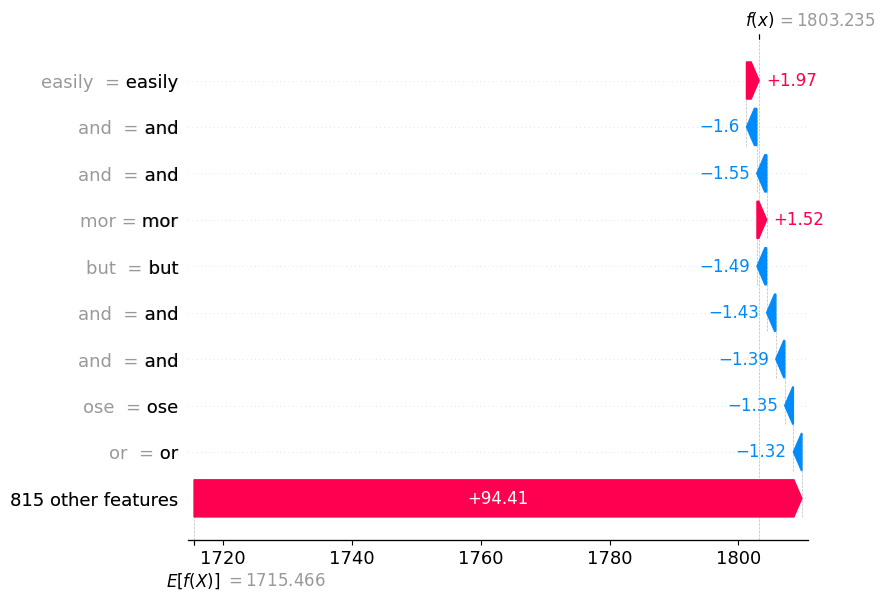

In [25]:
shap.plots.waterfall(shap_values[5])

In [ ]:
import shap

feature_names = tfidf_vectorizer.get_feature_names_out()
explainer = shap.Explainer(xgb_model.predict,train_text_features[1100:1115],   feature_names=feature_names)
shap_values = explainer(test_text_features[1100:1115], max_evals=4000)
print(shap_values.values.shape) # (5000, 16438, 2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


cuda


C:\Users\rhira\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


epoch
Root Mean Squared Error (RMSE): 64.68133543414508


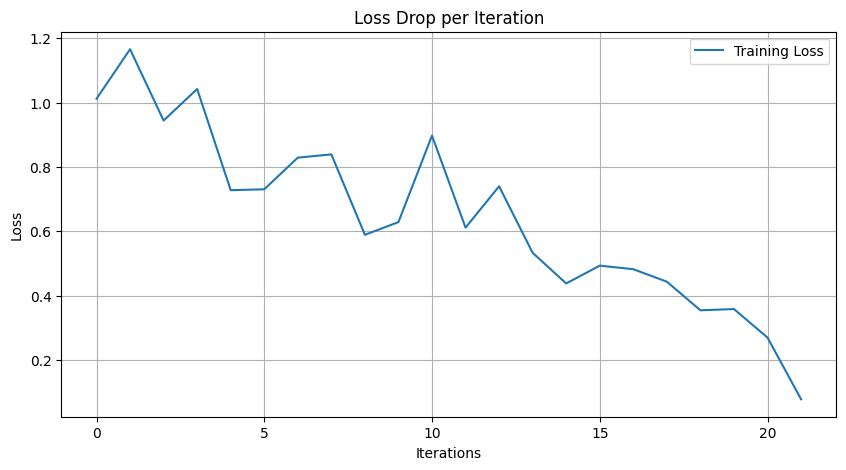